In [38]:
# IMPORTS

import numpy as np
from glob import glob
import noisereduce as nr
import random
import librosa.display
import IPython
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as k
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping


In [39]:
# DIRECTORY CONTAINING PREPROCESSED KICK SPECTROGRAMS
data_dir = '/Volumes/CE_CADDY/TRAINING_SAMPLES/Kicks_Preprocessed_0.5s'

In [40]:
# FUNCTIONS

## LOAD DATA
def load_data(path):
    X = []
    
    audiofiles = glob(data_dir + '/*.wav.npy')
    
    for file in audiofiles:
        
        X.append(np.load(file))
        
        
    return np.array(X)

## REMOVE NANS FROM DATA
def remove_nans(data):
    if np.isnan(data).sum() > 0:
        a = data.shape[1]
        b = data.shape[2]
        good_data_total = int(data.shape[0] - (np.isnan(data).sum() / (a * b)))
        data = data[~np.isnan(data)]
        data = data.reshape(good_data_total, a,b)
        return data
    return data

## POST-PROCESS AND PLAY GENERATED SPECTROGRAMS
def postproc_and_play(generated_spectrogram):
    #sample rate
    sr = 48000
    # random value to pitch down sample
    pdown = random.uniform(-30, -16)
    # spectrogram back to audio
    new_kick = librosa.griffinlim(generated_spectrogram, n_iter=32, hop_length=300)
    # noise reduction on audio
    new_kick_nr = nr.reduce_noise(y=new_kick, sr=sr, stationary=True)
    # pitch down audio by random amount
    new_kick_final = librosa.effects.pitch_shift(new_kick_nr, sr=sr, n_steps = pdown, bins_per_octave=16, res_type='kaiser_best')
    # display waveform and return player for audio file
    librosa.display.waveshow(new_kick_final,sr=sr)
    return IPython.display.Audio(new_kick_final, rate=sr)

In [41]:
# LOAD DATA
data = load_data(data_dir)

In [42]:
# CHECK DATA SHAPE BEFORE REMOVING NANS
data.shape

(6561, 256, 94)

In [43]:
# CHECK NANS IN DATA
np.isnan(data).sum()

0

In [44]:
# REMOVE NANS
data = remove_nans(data)

In [45]:
# CREATE TRAINING AND VALIDATION SETS
X_train = data[:5000, :, :]
X_valid = data[5000:6560, :, :]

Sampling layer which is called later in the function, takes in mean and log_var and randomly samples the coding from normal distribution.

In [46]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return k.random_normal(tf.shape(log_var)) * k.exp(log_var/2) + mean

In [47]:
codings_size = 10

encoder, mean and log_var take in same input from second layer hense not being sequential

In [48]:
inputs = layers.Input(shape=[256,94])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation='selu')(z)
z = layers.Dense(100, activation='selu')(z)
codings_mean = layers.Dense(codings_size)(z)
codings_log_var = layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean,codings_log_var])
variational_encoder = Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder

In [49]:
decoder_inputs = layers.Input(shape=[codings_size])
x = layers.Dense(100, activation='selu')(decoder_inputs)
x = layers.Dense(150, activation='selu')(x)
x = layers.Dense(256 * 94, activation='sigmoid')(x)
outputs = layers.Reshape([256, 94])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [50]:
_,_,codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

In [52]:
latent_loss = -0.5 * k.sum(
1 + codings_log_var - k.exp(codings_log_var) - k.square(codings_mean),
axis=-1)
variational_ae.add_loss(k.mean(latent_loss)/256*94)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [16]:
# variational_ae.summary()

In [59]:
# SOME VARIABLES FOR GENERATION
hop_length = 300
win_length = 1200
sr = 48000
s_devs = 1

In [54]:
es = EarlyStopping(patience=10,restore_best_weights=True)

history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=[X_valid, X_valid], callbacks=[es])

Epoch 1/100
40/40 [==============================] - 9s 186ms/step - loss: 13379843391488.0000 - val_loss: 8.1887
Epoch 2/100
40/40 [==============================] - 7s 179ms/step - loss: 20.4277 - val_loss: 5.6758
Epoch 3/100
40/40 [==============================] - 7s 178ms/step - loss: 18.3522 - val_loss: 4.7392
Epoch 4/100
40/40 [==============================] - 7s 181ms/step - loss: 14.2383 - val_loss: 2.5455
Epoch 5/100
40/40 [==============================] - 8s 206ms/step - loss: 4.1020 - val_loss: 1.2604
Epoch 6/100
40/40 [==============================] - 9s 224ms/step - loss: 2.5224 - val_loss: 1.0576
Epoch 7/100
40/40 [==============================] - 8s 206ms/step - loss: 1.6215 - val_loss: 0.3945
Epoch 8/100
40/40 [==============================] - 7s 185ms/step - loss: 1.3004 - val_loss: 0.2736
Epoch 9/100
40/40 [==============================] - 8s 202ms/step - loss: 1.0851 - val_loss: 0.2001
Epoch 10/100
40/40 [==============================] - 7s 181ms/step - loss:

In [61]:
# SAMPLE THE LATENT SPACE
codings = tf.random.normal(shape=[10, codings_size],stddev=s_devs)
images = variational_decoder(codings).numpy()

In [20]:
variational_ae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 94)]    0           []                               
                                                                                                  
 model (Functional)             [(None, 10),         3626870     ['input_1[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 model_1 (Functional)           (None, 256, 94)      3649914     ['model[0][2]']                  
                                                                                            

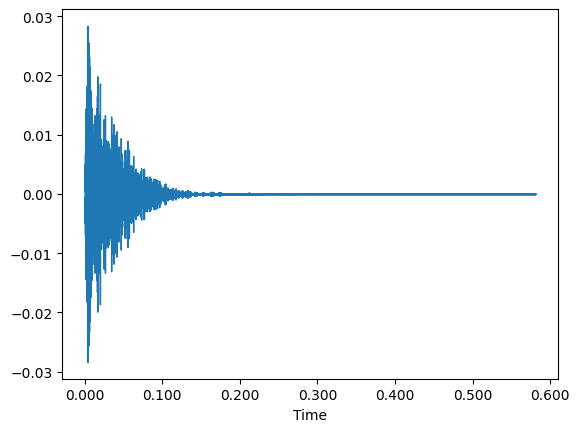

In [62]:
postproc_and_play(images[2])

In [ ]:
postproc_and_play(images[2])

In [ ]:
postproc_and_play(images[3])

In [ ]:
postproc_and_play(images[4])

In [ ]:
postproc_and_play(images[5])